In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install chart_studio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objects as go

     |████████████████████████████████| 71kB 3.5MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ecommerce_df = pd.read_csv('/content/drive/My Drive/datasets/ecommerce_data/data.csv',encoding="ISO-8859-1")
ecommerce_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
print(ecommerce_df.shape,'\n\n')
ecommerce_df.dtypes

(541909, 8) 




InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [ ]:
ecommerce_df['InvoiceDate'] = pd.to_datetime(ecommerce_df['InvoiceDate'])
ecommerce_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
ecommerce_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
#Above, we see that 135080 values in CustomerID column is null and since, we are dealing with the customer segmentation
#part, these rows are of no value to us, so we remove them from the dataframe

ecommerce_df = ecommerce_df.dropna(axis=0,subset=['CustomerID'])
print(ecommerce_df.shape)
ecommerce_df.isnull().sum()

(406829, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
#finding duplicate rows in the dataframe because they are just redundant and large number of duplicates can affect
#our model performance

ecommerce_df.duplicated(subset=None).sum()

5225

In [ ]:
#removing all duplicates except their first occurence
ecommerce_df.drop_duplicates(inplace=True)
ecommerce_df.shape

(401604, 8)

In [ ]:
#Since we have the data of online retail, our metrics can be revenue generated per month
#For this purpose, we need revenue for each month and for this purpose, we need to change InvoiceDate to year-month string

ecommerce_df['InvoiceYearMonth'] = ecommerce_df['InvoiceDate'].map(lambda date : 100*date.year + date.month)
ecommerce_df['Revenue'] = ecommerce_df['Quantity']*ecommerce_df['UnitPrice']
ecommerce_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [ ]:
revenue_df = ecommerce_df.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
revenue_df

,InvoiceYearMonth,Revenue
0,201012,552372.860
1,201101,473731.900
2,201102,435534.070
3,201103,578576.210
4,201104,425222.671
5,201105,647011.670
6,201106,606862.520
7,201107,573112.321
8,201108,615078.090
9,201109,929356.232


In [ ]:
#visualize the monthly distribution of revenue

data = [
        go.Scatter(
            x = revenue_df['InvoiceYearMonth'],
            y = revenue_df['Revenue']
        )
]

layout = go.Layout(
           xaxis = {'type':'category'},
           title = 'Monthly Revenue'
       ) 

fig = go.Figure(data = data, layout = layout)
pyoff.iplot(fig)
#fig.show()

In [ ]:
#from the plot we see that revenue increases after July 2011 and then it abruptly drops in december 2011 since our data in December is incomplete
#further we won't be considering december data in our analysis
print(ecommerce_df.groupby(['InvoiceYearMonth'])['Quantity'].sum())

InvoiceYearMonth
201012    295177
201101    268755
201102    262243
201103    343095
201104    277730
201105    367115
201106    356239
201107    361359
201108    385865
201109    536350
201110    568898
201111    666813
201112    203212
Name: Quantity, dtype: int64


In [ ]:
#Monthly revenue growth rate
revenue_df['MonthlyRevenueGrowth'] = revenue_df['Revenue'].pct_change() #pct_change() function used to find the percentage change between 2 consecutive values
revenue_df['MonthlyRevenueGrowth'] = revenue_df['MonthlyRevenueGrowth'].replace(np.nan,0)
revenue_df

,InvoiceYearMonth,Revenue,MonthlyRevenueGrowth
0,201012,552372.860,0.000000
1,201101,473731.900,-0.142369
2,201102,435534.070,-0.080632
3,201103,578576.210,0.328429
4,201104,425222.671,-0.265053
5,201105,647011.670,0.521583
6,201106,606862.520,-0.062053
7,201107,573112.321,-0.055614
8,201108,615078.090,0.073224
9,201109,929356.232,0.510956


In [ ]:
#visualize the monthly distribution of revenue

data = [
        go.Scatter(
            x = revenue_df['InvoiceYearMonth'],
            y = revenue_df['MonthlyRevenueGrowth']
        )
]

layout = go.Layout(
           xaxis = {'type':'category'},
           title = 'Monthly Revenue growth rate'
       ) 

fig = go.Figure(data = data, layout = layout)
pyoff.iplot(fig)

In [ ]:
#we see there is steep decrease in the month of April and then it abruptly increased in the month of may
#since revenue growth decreased, we need to see the reason for this abrupt increase
#The reason may be decrease in the number of customers or buying less products or even buying cheap products

In [ ]:
#Monthly Active Customers
monthly_active_customers = ecommerce_df.groupby(['InvoiceYearMonth'])['CustomerID'].nunique().reset_index()
monthly_active_customers

,InvoiceYearMonth,CustomerID
0,201012,948
1,201101,783
2,201102,798
3,201103,1020
4,201104,899
5,201105,1079
6,201106,1051
7,201107,993
8,201108,980
9,201109,1302


In [ ]:
data = [
        go.Bar(
            x = monthly_active_customers['InvoiceYearMonth'],
            y = monthly_active_customers['CustomerID'],
        )
]

layout = go.Layout(
    xaxis = {'type':'category'},
    title = 'Active users per month'
)

fig = go.Figure(data = data, layout = layout)
pyoff.iplot(fig)

In [ ]:
#We see a decrease in number of active customers in the month of April compared to March

In [ ]:
#finding out the number of products bought for each month

monthly_product_purchase = ecommerce_df.groupby(['InvoiceYearMonth'])['Quantity'].sum().reset_index()
monthly_product_purchase

,InvoiceYearMonth,Quantity
0,201012,295177
1,201101,268755
2,201102,262243
3,201103,343095
4,201104,277730
5,201105,367115
6,201106,356239
7,201107,361359
8,201108,385865
9,201109,536350


In [ ]:
data = [
        go.Bar(
            x = monthly_product_purchase['InvoiceYearMonth'],
            y = monthly_product_purchase['Quantity'],
        )
]

layout = go.Layout(
    xaxis = {'type':'category'},
    title = 'Number of products purchased per month'
)

fig = go.Figure(data = data, layout = layout)
pyoff.iplot(fig)

In [ ]:
#We also see a decrease in the number of products purchased in the month of April compared to March

In [ ]:
#calculating average revenue per order
avg_revenue_per_order = ecommerce_df.groupby(['InvoiceYearMonth'])['Revenue'].mean().reset_index()
avg_revenue_per_order

,InvoiceYearMonth,Revenue
0,201012,20.959735
1,201101,21.861186
2,201102,21.627474
3,201103,21.026901
4,201104,18.497593
5,201105,22.574637
6,201106,22.006909
7,201107,21.027015
8,201108,22.412115
9,201109,22.970321


In [ ]:
data = [
        go.Bar(
            x = avg_revenue_per_order['InvoiceYearMonth'],
            y = avg_revenue_per_order['Revenue'],
        )
]

layout = go.Layout(
    xaxis = {'type':'category'},
    title = 'Average revenue per order'
)

fig = go.Figure(data = data, layout = layout)
pyoff.iplot(fig)

In [ ]:
#so we observe every metric that is affecting the revenue for each month and decrese in these metrics for the month of April.

In [ ]:
first_purchase_date = ecommerce_df.groupby(['CustomerID'])['InvoiceDate'].min().reset_index()
first_purchase_date.columns = ['CustomerID','FirstPurchaseDate']
first_purchase_date['FirstPurchaseYearMonth'] = first_purchase_date['FirstPurchaseDate'].map(lambda date: 100*date.year + date.month)
ecommerce_df = pd.merge(ecommerce_df,first_purchase_date,on='CustomerID',how='left')
ecommerce_df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,FirstPurchaseDate,FirstPurchaseYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012


In [ ]:
ecommerce_df['UserType'] = 'New'
ecommerce_df.loc[ecommerce_df['InvoiceYearMonth']>ecommerce_df['FirstPurchaseYearMonth'],'UserType'] = 'Old'
ecommerce_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,FirstPurchaseDate,FirstPurchaseYearMonth,UserType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012,New
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New


In [ ]:
revenue_per_month_for_each_user_type = ecommerce_df.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
#filterring out the data of 2010-12 and 2011-12 for checking revenue from new customers and old customers
revenue_per_month_for_each_user_type = revenue_per_month_for_each_user_type.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")
revenue_per_month_for_each_user_type

,InvoiceYearMonth,UserType,Revenue
1,201101,New,202650.850
2,201101,Old,271081.050
3,201102,New,149105.400
4,201102,Old,286428.670
5,201103,New,189488.390
6,201103,Old,389087.820
7,201104,New,119561.811
8,201104,Old,305660.860
9,201105,New,115494.260
10,201105,Old,531517.410


In [ ]:
#visualize the monthly distribution of revenue

data = [
        go.Scatter(
            x = revenue_per_month_for_each_user_type.query("UserType=='Old'")['InvoiceYearMonth'],
            y = revenue_per_month_for_each_user_type.query("UserType=='Old'")['Revenue'],
            name = 'Old'
        ),

        go.Scatter(
            x = revenue_per_month_for_each_user_type.query("UserType=='New'")['InvoiceYearMonth'],
            y = revenue_per_month_for_each_user_type.query("UserType=='New'")['Revenue'],
            name = 'New'
        )
]


layout = go.Layout(
           xaxis = {'type':'category'},
           title = 'Monthly revenue through old and new customers'
       ) 

fig = go.Figure(data = data, layout = layout)
pyoff.iplot(fig)

In [ ]:
#from the graph it seems, we are not loosing old customers except for in the month of April, but we also see that we are not gaining much new customers
#for any business, gaining new customers is very important.
#To confirm our belief, we will check new customers ratio, i.e. for each month check the ratio of new vs old customer

In [ ]:
new_usertype_ratio = ecommerce_df.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()/(ecommerce_df.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() + ecommerce_df.query("UserType == 'Old'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique())
new_usertype_ratio = new_usertype_ratio.reset_index()
new_usertype_ratio = new_usertype_ratio.dropna()
new_usertype_ratio.columns = ['InvoiceYearMonth','NewUserRatio']
new_usertype_ratio


,InvoiceYearMonth,NewUserRatio
1,201101,0.537676
2,201102,0.476190
3,201103,0.431373
4,201104,0.332592
5,201105,0.258573
6,201106,0.223597
7,201107,0.192346
8,201108,0.170408
9,201109,0.228879
10,201110,0.247018


In [ ]:

old_usertype_ratio = ecommerce_df.query("UserType == 'Old'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()/(ecommerce_df.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() + ecommerce_df.query("UserType == 'Old'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique())
old_usertype_ratio = old_usertype_ratio.reset_index()
old_usertype_ratio = old_usertype_ratio.dropna()
old_usertype_ratio.columns = ['InvoiceYearMonth','OldUserRatio']
old_usertype_ratio


,InvoiceYearMonth,OldUserRatio
1,201101,0.462324
2,201102,0.523810
3,201103,0.568627
4,201104,0.667408
5,201105,0.741427
6,201106,0.776403
7,201107,0.807654
8,201108,0.829592
9,201109,0.771121
10,201110,0.752982


In [ ]:
data = [
        go.Bar(
            name='Old',
            x=old_usertype_ratio.query("InvoiceYearMonth!=201012 and InvoiceYearMonth!=201112")['InvoiceYearMonth'],
            y=old_usertype_ratio.query("InvoiceYearMonth!=201012 and InvoiceYearMonth!=201112")['OldUserRatio']
        ),

        go.Bar(
            name='New',
            x=new_usertype_ratio.query("InvoiceYearMonth!=201012 and InvoiceYearMonth!=201112")['InvoiceYearMonth'],
            y=new_usertype_ratio.query("InvoiceYearMonth!=201012 and InvoiceYearMonth!=201112")['NewUserRatio']
        )
]

layout = go.Layout(
           xaxis = {'type':'category'},
           title = 'Monthly new and old customer ratio'
       )

fig = go.Figure(data=data,layout=layout)
fig.update_layout(barmode='stack')
pyoff.iplot(fig)

In [ ]:
#from the plot we can see that new customer addition has decreased with passing months and thus our earlier assumption was true
#Another important factor for a business is the customer retention rate. So, now we will look at the companies retention rate.
#we will perform cohort retention analysis
#Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time 
#or is only appearing to improve because of growth.

#Cohort analysis proves to be valuable because it helps to separate growth metrics from engagement metrics as growth can easily mask engagement problems.
#In reality, the lack of activity of the old users is being hidden by the impressive growth numbers of new users, 
#which results in concealing the lack of engagement from a small number of people.

In [ ]:
year_InvoiceDate = ecommerce_df['InvoiceDate'].dt.year
month_InvoiceDate = ecommerce_df['InvoiceDate'].dt.month
year_firstPurchaseDate = ecommerce_df['FirstPurchaseDate'].dt.year
month_firstPurchaseDate = ecommerce_df['FirstPurchaseDate'].dt.month
year_diff = year_InvoiceDate - year_firstPurchaseDate
month_diff = month_InvoiceDate - month_firstPurchaseDate
ecommerce_df['CohortIndex'] = year_diff*12 + month_diff + 1
ecommerce_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue,FirstPurchaseDate,FirstPurchaseYearMonth,UserType,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,2010-12-01 08:26:00,201012,New,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,2010-12-01 08:26:00,201012,New,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,2010-12-01 08:26:00,201012,New,1


In [ ]:
#In this cohort table we are showing number of active users

cohort_data = ecommerce_df.groupby(['FirstPurchaseYearMonth','CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_count = cohort_data.pivot_table(index='FirstPurchaseYearMonth',columns='CohortIndex',values='CustomerID')
cohort_count

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
FirstPurchaseYearMonth,,,,,,,,,,,,,
201012,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
201101,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
201102,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
201103,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
201104,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
201105,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
201106,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
201107,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#the first column in the chart is active user in that month and the following columns show how the many remaining users are still using the service
#in the subsequent months
#Now we convert absolute values into percentage to see the percentage retention

In [ ]:
cohort_size = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_size,axis=0)
retention = retention.round(3)*100
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
FirstPurchaseYearMonth,,,,,,,,,,,,,
201012,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
201101,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
201102,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
201103,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
201104,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
201105,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
201106,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
201107,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#we see that at the end of November 2011, only 15% of customers that did their first purchase in january 2011 were retained
#Now we will plot the heat map for this cohort table for better visualization purpose

In [ ]:
def get_month(x):
  return dt.datetime(x.year,x.month,1)

dates = ecommerce_df['InvoiceDate'].apply(get_month)
dates = dates.unique()
dates = pd.to_datetime(dates)
data = [
        go.Heatmap(
            z = retention.values,
            x = retention.columns,
            y = dates,
            colorscale='RdBu'
        )
]
layout = go.Layout(
           xaxis = {'type':'category'},
           title = 'Cohort retention rate of customers'
       )

fig = go.Figure(data = data,layout=layout)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000
    
)
pyoff.iplot(fig)

In [ ]:
#Now we will perform customer segmentation based on the RFM(recency-frequency-monetary) value
#we will have 3 segments namely low value, mid value, and high value
#low value:-Not very frequent buyers and generate less positive/ zero or maybe negative revenue
#mid value:- Frequent and generating moderate revenue
#High value:-High activity, revenue.

#for this we need to genrate recency, frequency and monetary value and apply unsupervised machine learning to identify different groups

In [ ]:
ecommerce_user = pd.DataFrame(ecommerce_df['CustomerID'].unique())
ecommerce_user.columns = ['CustomerID']
ecommerce_recent_purchase = ecommerce_df.groupby(['CustomerID']).InvoiceDate.max().reset_index()
ecommerce_recent_purchase.columns = ['CustomerID','RecentPurchaseDate']
ecommerce_recent_purchase['Recency'] = (ecommerce_recent_purchase['RecentPurchaseDate'].max()-ecommerce_recent_purchase['RecentPurchaseDate']).dt.days
ecommerce_user = pd.merge(ecommerce_user,ecommerce_recent_purchase[['CustomerID','Recency']],on='CustomerID')
print(ecommerce_user.describe(),'\n\n')
ecommerce_user.head()

         CustomerID      Recency
count   4372.000000  4372.000000
mean   15299.677722    91.047118
std     1722.390705   100.765435
min    12346.000000     0.000000
25%    13812.750000    16.000000
50%    15300.500000    49.000000
75%    16778.250000   142.000000
max    18287.000000   373.000000 




,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,12583.0,2
3,13748.0,95
4,15100.0,329


In [ ]:
#we see that average recency is 90 days but median recency is 49 days

data = [
        go.Histogram(
            x = ecommerce_user['Recency']
        )
]

layout = go.Layout(
              title = 'Recency'
          )

fig = go.Figure(data=data,layout=layout)
pyoff.iplot(fig)

In [ ]:
#Now we apply K mean clustering on the recency data and calculate the recency score. For the most accurate recency score
#we must be able to know the optimal value of K in the k mean clustering algorithm. For knowing the optimal value of K
#we apply elbow method. Elbow method helps to select the optimal number of clusters by fitting the model with a range of values for K

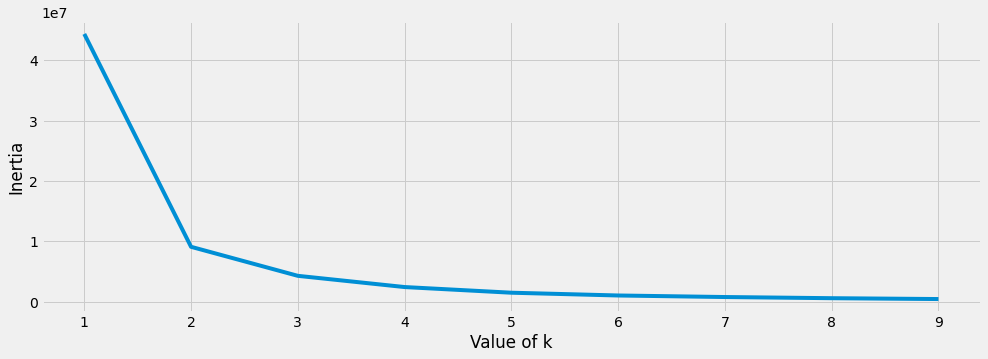

In [ ]:
mapping = {}
ecommerce_recency = ecommerce_user[['Recency']]
for k in range(1,10):
  kmeans = KMeans(n_clusters=k,max_iter=1000).fit(ecommerce_recency)
  ecommerce_recency["clusters"] = kmeans.labels_
  mapping[k] = kmeans.inertia_
plt.figure(figsize=(15,5))
plt.plot(list(mapping.keys()),list(mapping.values()))
plt.xlabel("Value of k")
plt.ylabel("Inertia")
plt.show()

In [ ]:
#from the plot we see that elbow is formed at 3 clusters, we choose k=3 here;

kmeans = KMeans(n_clusters=3).fit(ecommerce_user[['Recency']])
ecommerce_user['RecencyGroup'] = kmeans.predict(ecommerce_user[['Recency']])

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

ecommerce_user = order_cluster('RecencyGroup', 'Recency',ecommerce_user,False)
ecommerce_user.head()

,CustomerID,Recency,RecencyGroup
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [ ]:
ecommerce_user.groupby(['RecencyGroup'])['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyGroup,,,,,,,,
0,634.0,294.372240,45.419375,224.0,256.00,287.0,329.0,373.0
1,816.0,151.533088,38.494508,91.0,116.00,150.0,184.0,222.0
2,2922.0,30.039357,24.803359,0.0,8.25,23.0,49.0,90.0


In [ ]:
# 2 covers most recent customers and 0 covers least recent customers
#Now, we will create frequency clusters and for that we need to find total number of orders for each customer

ecommerce_frequency = ecommerce_df.groupby(['CustomerID']).InvoiceDate.count().reset_index()
ecommerce_frequency.columns = ['CustomerID','Frequency']

ecommerce_user = pd.merge(ecommerce_user,ecommerce_frequency,on='CustomerID')
print(ecommerce_user.describe(),'\n\n')
ecommerce_user.head()

         CustomerID      Recency  RecencyGroup    Frequency
count   4372.000000  4372.000000   4372.000000  4372.000000
mean   15299.677722    91.047118      1.523330    91.858188
std     1722.390705   100.765435      0.734579   229.223566
min    12346.000000     0.000000      0.000000     1.000000
25%    13812.750000    16.000000      1.000000    17.000000
50%    15300.500000    49.000000      2.000000    41.000000
75%    16778.250000   142.000000      2.000000    99.250000
max    18287.000000   373.000000      2.000000  7812.000000 




,CustomerID,Recency,RecencyGroup,Frequency
0,17850.0,301,0,309
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


In [ ]:
data = [
        go.Histogram(
            x = ecommerce_user['Frequency']
        )
]

layout = go.Layout(
              title = 'Frequency'
          )

fig = go.Figure(data=data,layout=layout)
pyoff.iplot(fig)

In [ ]:
#we see that frequency greater than 500 is very few so for better analysis of histogram, we only take frequency less than 1000
data = [
        go.Histogram(
            x = ecommerce_user.query('Frequency<500')['Frequency']
        )
]

layout = go.Layout(
              title = 'Frequency'
          )

fig = go.Figure(data=data,layout=layout)
pyoff.iplot(fig)

In [ ]:
kmeans = KMeans(n_clusters=3).fit(ecommerce_user[['Frequency']])
ecommerce_user['FrequencyGroup'] = kmeans.predict(ecommerce_user[['Frequency']])
ecommerce_user = order_cluster('FrequencyGroup','Frequency',ecommerce_user,True)
ecommerce_user.groupby(['FrequencyGroup'])['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyGroup,,,,,,,,
0,4111.0,60.122355,61.158622,1.0,16.00,37.0,85.0,285.0
1,257.0,510.287938,327.222095,286.0,338.00,409.0,545.0,2759.0
2,4.0,5824.250000,1449.742592,4459.0,4960.75,5513.0,6376.5,7812.0


In [ ]:
# Now we cluster our customers based on the revenue using the same approach as above

ecommerce_revenue = ecommerce_df.groupby(['CustomerID']).Revenue.sum().reset_index()
ecommerce_revenue.columns = ['CustomerID','Revenue']

ecommerce_user = pd.merge(ecommerce_user,ecommerce_revenue,on='CustomerID')
print(ecommerce_user.describe(),'\n\n')
ecommerce_user.head()

         CustomerID      Recency  ...  FrequencyGroup        Revenue
count   4372.000000  4372.000000  ...     4372.000000    4372.000000
mean   15299.677722    91.047118  ...        0.060613    1893.531433
std     1722.390705   100.765435  ...        0.242451    8218.696204
min    12346.000000     0.000000  ...        0.000000   -4287.630000
25%    13812.750000    16.000000  ...        0.000000     291.795000
50%    15300.500000    49.000000  ...        0.000000     644.070000
75%    16778.250000   142.000000  ...        0.000000    1608.335000
max    18287.000000   373.000000  ...        2.000000  279489.020000

[8 rows x 6 columns] 




,CustomerID,Recency,RecencyGroup,Frequency,FrequencyGroup,Revenue
0,17850.0,301,0,309,1,5303.48
1,14688.0,7,2,356,1,5055.61
2,15311.0,0,2,2478,1,59284.19
3,14527.0,2,2,1010,1,7709.69
4,17511.0,2,2,1076,1,88125.38


In [ ]:
#we see that frequency greater than 500 is very few so for better analysis of histogram, we only take frequency less than 1000
data = [
        go.Histogram(
            x = ecommerce_user['Revenue']
        )
]

layout = go.Layout(
              title = 'Revenue/Monetary-Value'
          )

fig = go.Figure(data=data,layout=layout)
pyoff.iplot(fig)

In [ ]:
#from the plot we see that revenue greater than 10k and less than -200 are very less, so for better analysis we look at the histogram for revenue less than 10k.
# we have some customers with negative revenue as well
data = [
        go.Histogram(
            x = ecommerce_user.query('Revenue<10000 and Revenue>-500')['Revenue']
        )
]

layout = go.Layout(
              title = 'Revenue/Monetary-Value'
          )

fig = go.Figure(data=data,layout=layout)
pyoff.iplot(fig)

In [ ]:
kmeans = KMeans(n_clusters=3).fit(ecommerce_user[['Revenue']])
ecommerce_user['RevenueGroup'] = kmeans.predict(ecommerce_user[['Revenue']])
ecommerce_user = order_cluster('RevenueGroup','Revenue',ecommerce_user,True)
ecommerce_user.groupby(['RevenueGroup'])['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueGroup,,,,,,,,
0,4346.0,1428.986998,2429.708792,-4287.63,290.37,639.76,1568.1625,28658.88
1,23.0,58473.576087,29227.302358,30300.82,35079.28,52750.84,60987.3650,132458.73
2,3.0,241083.226667,47963.737800,187322.17,221880.33,256438.49,267963.7550,279489.02


In [ ]:
ecommerce_user['OverallScore'] = ecommerce_user['FrequencyGroup'] + ecommerce_user['RecencyGroup'] + ecommerce_user['RevenueGroup']
ecommerce_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Recency,Frequency,Revenue
OverallScore,,,
0,294.361769,22.586098,395.765498
1,151.820418,39.035670,700.302080
2,31.961293,75.640361,1448.076585
3,12.821862,471.522267,7668.789636
4,5.750000,1343.333333,63202.755833
5,2.000000,3617.666667,158783.061667


In [ ]:
ecommerce_user['RFMValue'] = 'Low RFM'
ecommerce_user.loc[ecommerce_user['OverallScore']>1,'RFMValue'] = 'Mid RFM'
ecommerce_user.loc[ecommerce_user['OverallScore']>3,'RFMValue'] = 'High RFM'
ecommerce_user.head()

,CustomerID,Recency,RecencyGroup,Frequency,FrequencyGroup,Revenue,RevenueGroup,OverallScore,RFMValue
0,17850.0,301,0,309,1,5303.48,0,1,Low RFM
1,14688.0,7,2,356,1,5055.61,0,3,Mid RFM
2,14527.0,2,2,1010,1,7709.69,0,3,Mid RFM
3,13408.0,1,2,501,1,27487.41,0,3,Mid RFM
4,13767.0,1,2,399,1,16945.71,0,3,Mid RFM


In [ ]:
#thus we have clustered the customers based on their RFM value in three domains namely low, mid, high. Now since we have customers clustered
#in different domains, we can now perform lots of further analysis like churn prediction,customer lifetime value prediction,next day purchase prediction etc.

#from the above customer segmentation, we get to know which customers we should target most and which customers are more helpful in increase revenue
# and thus we can think of how to convert customers with low RFM into high RFM customers


In [ ]:
data = [
        go.Scatter(
        x=ecommerce_user.query("RFMValue == 'Low RFM'")['Frequency'],
        y=ecommerce_user.query("RFMValue == 'Low RFM'")['Revenue'],
        mode='markers',
        name='Low Revenue',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'red',
            opacity= 1
           )
      ),
      go.Scatter(
        x=ecommerce_user.query("RFMValue == 'Mid RFM'")['Frequency'],
        y=ecommerce_user.query("RFMValue == 'Mid RFM'")['Revenue'],
        mode='markers',
        name='Mid Revenue',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'yellow',
            opacity= 1
           )
      ),
      go.Scatter(
        x=ecommerce_user.query("RFMValue == 'High RFM'")['Frequency'],
        y=ecommerce_user.query("RFMValue == 'High RFM'")['Revenue'],
        mode='markers',
        name='High Revenue',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 1
           )
      ),
]

layout = go.Layout(
    yaxis= {'title': "Revenue"},
    xaxis= {'title': "Frequency"},
    title='Revenue vs Frequency'
)

fig = go.Figure(data=data, layout=layout)
pyoff.iplot(fig)

In [ ]:
data = [
        go.Scatter(
        x=ecommerce_user.query("RFMValue == 'Low RFM'")['Recency'],
        y=ecommerce_user.query("RFMValue == 'Low RFM'")['Revenue'],
        mode='markers',
        name='Low Revenue',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'red',
            opacity= 1
           )
      ),
      go.Scatter(
        x=ecommerce_user.query("RFMValue == 'Mid RFM'")['Recency'],
        y=ecommerce_user.query("RFMValue == 'Mid RFM'")['Revenue'],
        mode='markers',
        name='Mid Revenue',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'yellow',
            opacity= 1
           )
      ),
      go.Scatter(
        x=ecommerce_user.query("RFMValue == 'High RFM'")['Recency'],
        y=ecommerce_user.query("RFMValue == 'High RFM'")['Revenue'],
        mode='markers',
        name='High Revenue',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 1
           )
      ),
]

layout = go.Layout(
    yaxis= {'title': "Revenue"},
    xaxis= {'title': "Recency"},
    title='Revenue vs Recency'
)

fig = go.Figure(data=data, layout=layout)
pyoff.iplot(fig)

In [ ]:
data = [
        go.Scatter(
        x=ecommerce_user.query("RFMValue == 'Low RFM'")['Recency'],
        y=ecommerce_user.query("RFMValue == 'Low RFM'")['Frequency'],
        mode='markers',
        name='Low Frequency',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'red',
            opacity= 1
           )
      ),
      go.Scatter(
        x=ecommerce_user.query("RFMValue == 'Mid RFM'")['Recency'],
        y=ecommerce_user.query("RFMValue == 'Mid RFM'")['Frequency'],
        mode='markers',
        name='Mid Frequency',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'yellow',
            opacity= 1
           )
      ),
      go.Scatter(
        x=ecommerce_user.query("RFMValue == 'High RFM'")['Recency'],
        y=ecommerce_user.query("RFMValue == 'High RFM'")['Frequency'],
        mode='markers',
        name='High Frequency',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 1
           )
      ),
]

layout = go.Layout(
    yaxis= {'title': "Frequency"},
    xaxis= {'title': "Recency"},
    title='Frequency vs Recency'
)

fig = go.Figure(data=data, layout=layout)
pyoff.iplot(fig)

In [ ]:
#The graphs show clear distinction between all three clusters: Low, Mid and High